In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import sys

tfd = tfp.distributions

from elicit.core.run import prior_elicitation
from elicit.user.design_matrices import load_design_matrix_binomial
from elicit.user.generative_models import BinomialModel
from elicit.user.custom_functions import quantiles_per_ypred

from elicit.manuscript_non_parametric_joint_prior.functions.independent_binomial_prior_checks import run_sensitivity_binom, prep_sensitivity_res, plot_sensitivity_binom
from elicit.manuscript_non_parametric_joint_prior.functions.convergence_diagnostics import plot_conv_diagnostics
from elicit.manuscript_non_parametric_joint_prior.functions.preprocess_sim_res_binom import prep_sim_res_binom
from elicit.manuscript_non_parametric_joint_prior.functions.binomial_model_averaging import run_model_averaging, plot_learned_priors
from elicit.plotting.sensitivity_func import plot_elicited_stats_binom, plot_loss_binom, plot_prior_binom

# Binomial model
This notebooks implements Simulation Study 1 in Bockting et al. (2024). Please consult this reference for further details about the setup.

Bockting, F., Radev S. T., & Bürkner P. C. (2024) Expert-elicitation method for non-parametric joint priors using normalizing flows. Preprint at [https://arxiv.org/abs/2411.15826](https://arxiv.org/abs/2411.15826)

## Preparation

In [ ]:
# set seed
seed = 1
# set path to oracle data and to simulation results
path_sim_res = f"elicit/results/deep_prior/binomial_model_{seed}"
path_expert = f"elicit/results/deep_prior/binomial_model_{seed}/expert"
# set path for saving sensitivity results
path_sensitivity_res = f"elicit/elicit/results/deep_prior/binomial_model_{seed}/sensitivity_results"

## Model and Expert data
### Generative model
Binomial model with a logit link (sigmoid response function) and one continuous predictor~$x=1,\ldots,50$, scaled by its standard deviation:
\begin{align}
    \begin{split}
        y_i &\sim \text{Binomial}(p_i, 30)\\
        p_i &= \text{sigmoid}(\beta_0+\beta_1x_i)\\
        \beta_0, \beta_1 &\sim p_\lambda(\beta_0, \beta_1) \\
        \theta &\equiv (\beta_0,\beta_1) 
    \end{split}
\end{align}
The goal is to learn a joint prior for the model parameters $\beta_0$ (intercept) and $\beta_1$ (slope), assuming independence between these parameters. 

### Elicited statistics
As elicited statistics, we select two observations from the continuous predictor $x$, denoted by $x_0$ and $x_1$, which correspond to the $25\%$ and $75\%$ quantiles of $x_i$. We select specific quantiles rather than randomly sampling two observations from the predictor to avoid the observations being too close together, which would reduce informativeness. From the two selected observations, we compute five quantiles from the prior predictive distribution to represent the elicited statistics. 

To obtain the ``expert''-elicited statistics, we define a true prior that represents the ground truth and simulate from the generative model in forward mode, computing the corresponding true-elicited statistics. 

The *true* joint prior is defined by independent normal distributions for each model parameter: $\beta_0 \sim \text{Normal}(0.1, 0.1)$ and $\beta_1 \sim \text{Normal}(-0.1, 0.3)$. 

### Implementation

In [7]:
def run_sim(seed):

    prior_elicitation(
        model_parameters=dict(
            b0=dict(param_scaling=1.0),
            b1=dict(param_scaling=1.0),
            independence=dict(corr_scaling=0.1)
        ),
        normalizing_flow=True,
        expert_data=dict(
            from_ground_truth=True,
            simulator_specs={
                "b0": tfd.Normal(0.1, 0.1),
                "b1": tfd.Normal(-0.1, 0.3),
            },
            samples_from_prior=10_000,
        ),
        generative_model=dict(
            model=BinomialModel,
            additional_model_args={
                "total_count": 30,
                "design_matrix": load_design_matrix_binomial(50)
                },
            discrete_likelihood = True,
            softmax_gumble_specs = {
                "temperature": 1.,
                "upper_threshold": 30
            }
        ),
        target_quantities=dict(
            ypred=dict(
                elicitation_method=None,
                custom_elicitation_method=dict(
                    function=quantiles_per_ypred,
                    additional_args={
                        "quantiles_specs": (5, 25, 50, 75, 95)
                        }
                    ),
                loss_components="by-group"
            )
        ),
        optimization_settings=dict(
            optimizer_specs={
                "learning_rate": 0.0001,
                "clipnorm": 1.0,
            }
        ),
        training_settings=dict(
            method="deep_prior",
            sim_id="binomial_model",
            seed=seed,
            epochs=600,
            view_ep=100
        ),
    )

## Training
For optimization we employ mini-batch stochastic gradient descent with automatic differentiation, facilitated by the (explicit or implicit) reparameterization trick. See our papers for details (Bockting et al., 2024a, 2024b).

+ Bockting, F., Radev S. T., & Bürkner P. C. (2024a) Expert-elicitation method for non-parametric joint priors using normalizing flows. Preprint at https://arxiv.org/abs/2411.15826
+ Bockting, F., Radev, S. T. & Bürkner, P. C. (2024b). Simulation-based prior knowledge elicitation for parametric Bayesian models. Scientific Reports 14, 17330 (2024). https://doi.org/10.1038/s41598-024-68090-7

In [8]:
# run training to learn prior distributions
run_sim(seed)

epoch_time: 1.908 sec
Epoch: 0, loss: 2.86908,                      lr: 0.000100
epoch_time: 2.106 sec
Epoch: 100, loss: 2.11467,                      lr: 0.000100
Estimated time until completion: 00:15:03
epoch_time: 1.781 sec
Epoch: 200, loss: 1.29210,                      lr: 0.000100
Estimated time until completion: 00:12:19
epoch_time: 1.852 sec
Epoch: 300, loss: 0.34678,                      lr: 0.000100
Estimated time until completion: 00:09:04
epoch_time: 0.975 sec
Epoch: 400, loss: 0.19176,                      lr: 0.000100
Estimated time until completion: 00:05:43
epoch_time: 1.015 sec
Epoch: 500, loss: 0.18815,                      lr: 0.000100
Estimated time until completion: 00:02:36
Done :)


## Sensitivity Analysis

To assess the *informativeness* of the selected set of elicited statistics, we conduct a sensitivity analysis.
In this context, *informativeness* refers to the relevance of the elicited statistics for learning the prior distributions.

In a sensitivity analysis, we systematically vary one aspect of the prior distribution at a time while keeping all other aspects constant. For each specific change in the prior, we run the generative model in forward mode by sampling from the prior, then from the likelihood, and subsequently computing the target quantities and elicited statistics. Sensitivity analysis enables us to assess how changes in one aspect of the prior distribution impact each elicited statistic. If we observe no variation in a particular elicited statistic for a given prior variation, this statistic does not provide any useful information for the learning algorithm to determine the corresponding aspect of the prior. This approach can help inform the selection of elicited statistics and identify which aspects of the prior are most likely to remain unidentifiable given the current set of expert information.

In [4]:
# variation of hyperparameter values
mu0_seq = [-0.4, -0.2, 0.0, 0.2, 0.4]
mu1_seq = [-0.4, -0.2, 0.0, 0.2, 0.4]
sigma0_seq = [0.01, 0.1, 0.3, 0.6, 1.0]
sigma1_seq = [0.01, 0.1, 0.3, 0.6, 1.0]

# run sensitivity analysis
run_sensitivity_binom(
    seed, path_sensitivity_res, mu0_seq, mu1_seq, sigma0_seq, sigma1_seq
)

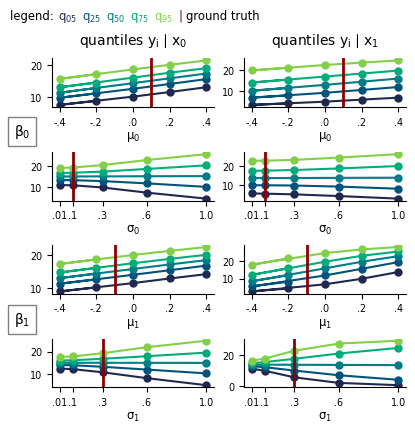

In [6]:
# preprocessing of simulation results
df_sim_res = prep_sensitivity_res(path_sensitivity_res)
# plot results
plot_sensitivity_binom(df_sim_res)

## Convergence Check and Learned Priors
### Elicited statistics
The final learned elicited statistics are shown in the first two plots from the left. Each true quantile (x-axis) is plotted against its corresponding learned quantile (y-axis). Points that align perfectly with the diagonal dashed line represent a perfect match between true and learned quantiles. Points above the diagonal indicate that the learned quantiles are higher than the true ones (and vice versa for lower points). Additionally, in the rightmost plot, we present the true (red) and learned (orange) correlations between the marginal priors. Results indicate that the elicited statistics, including the correlations, are accurately learned.

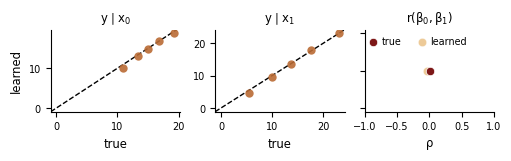

In [4]:
# read oracle data and extract simulation results
prior_expert = pd.read_pickle(path_expert+"/prior_samples.pkl")
prior_res_agg = tf.expand_dims(
    pd.read_pickle(path_sim_res+"/prior_samples.pkl")[0,:,:],
    -1)
elicit_res_agg = tf.expand_dims(
    pd.read_pickle(path_sim_res+"/elicited_statistics.pkl")["custom_ypred"][0,:,:], 
    -1)
cor_res_agg = tf.expand_dims(
    pd.read_pickle(path_sim_res+"/elicited_statistics.pkl")["correlation"][0,:], 
    -1)

# plot elicited statistics
plot_elicited_stats_binom(
    prior_expert, path_expert, path_sim_res, elicit_res_agg,
    prior_res_agg, cor_res_agg, save_fig=False
)

### Convergence diagnostics (a)
A visual inspection of the learning trajectories indicates satisfactory convergence for all quantities of interest. This includes the total loss, the individual loss components (upper row), as well as the means and standard deviations of the marginal priors (lower row). Overall, we conclude that the training process was successful.

### Learned prior distributions (b)
The learned marginals closely align with the ground truth (indicated in red).

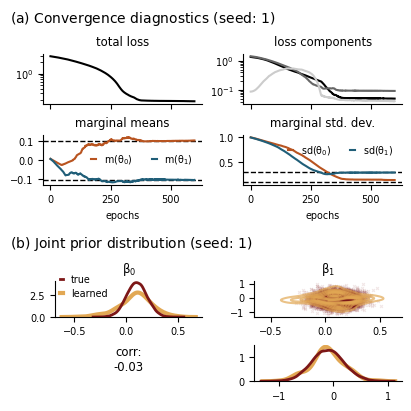

In [3]:
# plot convergence of all quantities of interest and learned prior for seed with highest slope
plot_prior_binom(
    path_sim_res, path_expert, 
    file=None, seed=seed, save_fig=False
)